<a href="https://colab.research.google.com/github/lopesmatheus/COA19-PythonSimu/blob/main/Main_PIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIE - Apprentissage par renforcement pour le contrôle optimal des systèmes d’air - cas basique

Ce notebook a pour objet de répondre au besoin exprimé par Liebherr Aerospace et qui s'inscrit dans le PIE-COA19 "Apprentissage par renforcement pour le contrôle optimal des systèmes d'air". Dans ce notebook, nous mettons en place deux algorithmes d'apprentissage par renforcement (DDPG et SAC). Avant de s'attaquer au problème réel, nous tentons de contrôler un pendule inversé à l'aide de ces deux algorithmes pour vérifier leur bon fonctionnement avant de s'attaquer aux cas réel dans l'autre notebook. 
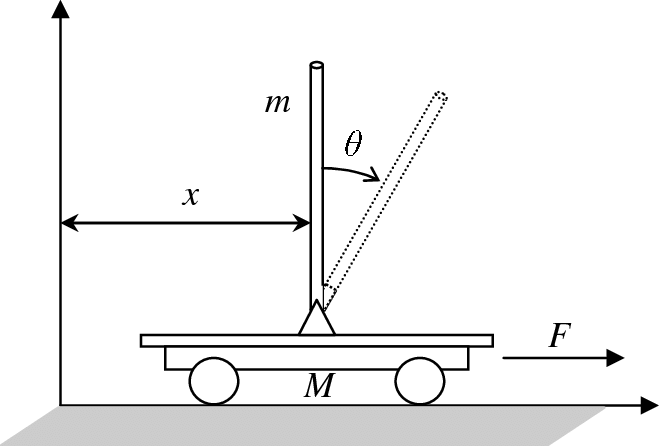

0. [Prérequis](#sec0)
    1. [À jouer sous Colab](#sec0-1)
    2. [Modules](#sec0-2)
1. [Environnements](#sec1)
2. [Agent](#sec2)
3. [Algorithmes (Actor-Critic)](#sec3)
    1. [Deep-Deterministic Policy Gradient (DDPG)](#sec3-1)
        1. [Essai sur environnement jouet CarPend](#sec3-1-1)
    2. [Soft Actor-critic (SAC)](#sec3-2)
        1. [Essai sur environnement jouet CarPend](#sec3-2-1)
4. [Évolution des rewards selon les algorithmes](#sec4)

# <a id="sec0"></a> 0. Prérequis

### <a id="sec0-1"></a> 0.1. À jouer sous Colab

À exécuter si le notebook est joué sous Colab ou en local et que les librairies suivantes ne sont pas installées.

In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [ ]:
!pip install pytorch

### <a id="sec0-2"></a> 0.2. Modules

In [1]:
import gym
import time
import shutil
import pandas as pd
import numpy as np
import random
import torch
from torch import nn
from statistics import mean
import matplotlib.pyplot as plt
import copy
from scipy.integrate import odeint

# <a id="sec1"></a> 1. Environnements

### <a id="sec1-1"></a> Environnement jouet : CarPend

La classe ci-dessous nous permet de mettre en place le  pendule inversé, qui nous servira d'environnement de simulation pour nos deux algorithmes. 

La dynamique du pendule inversé est complèxe, et est modélisée par 4 variables d'état : $(x,\dot x, \theta, \dot\theta )$ et les équations suivantes ($M$ étant la masse du chariot, $m$ celle du pendule, et $b$ le coefficient de frottement de l'air) : 
\begin{equation}
  \begin{cases}
    \ddot \theta = \dfrac{m\cdot g \cdot l\cdot sin(\theta)-m\cdot l\cdot cos(\theta)\cdot \ddot x - b\cdot \dot \theta}{m\cdot l^2} \\
    \ddot x = \dfrac{f-\ddot \theta \cdot m \cdot l \cdot cos(\theta)+m\cdot l \cdot \dot \theta^2 sin(\theta)}{M+m}
  \end{cases}
\end{equation}

In [2]:

class CarPend: 
    def __init__(self, max_time=500):
        # Définit les paramètres physiques de l'environnement

        self.M = 400/1000  # Masse du chariot
        self.m = 50/1000  # Masse du pendule
        self.L = 0.3  # Longueur de la tige
        self.g = 9.81  # Accélération due à la gravité
        self.b = 0.01  # Coefficient de frottement de l'air


        self.nb_actions=1 # La force appliquée au chariot
        self.state_size=4 #4 variables d'état

        # Définit l'espace d'action et l'espace d'observation de l'environnement
        self.action_space = gym.spaces.Box(-1.0, 1.0, (1,), np.float64) # l'eespace d'actions est continu
        self.observation_space = gym.spaces.Box(np.array([-5.0, -10.0, -2.0*np.pi, -10.0]), np.array([5.0, 10.0, 2.0*np.pi, 10.0]), (4,), np.float64) #L'espace d'état est continu

        # Initialisation d'autres paramètres

        self.dt = 0.01  # Pas de temps
        self.count = 0  # Compteur d'étapes effectuées
        self.max_time = max_time  # Temps maximum pour un épisode

        # Initialisation du chariot et du pendule

        self.x = 0  # Position du chariot
        self.xp = 0  # Vitesse du chariot
        self.xpp = 0  # Accélération du chariot
        self.theta = 0  # Angle de la tige par rapport à la verticale
        self.thetap = 0  # Vitesse angulaire de la tige
        self.thetapp = 0  # Accélération angulaire de la tige

    def reset(self):

        # Réinitialise les états du chariot et du pendule à une valeur par défaut
        self.x = 0
        self.xp = 0
        
        self.count = 0
        # Initialise l'angle de la tige à une valeur aléatoire proche de zéro (pour être en déséquilibre)
        self.theta = np.random.uniform(-np.pi/100., np.pi/100.) #angle entre -1.8 et 1.8°
        self.thetap = 0 #Vitesse initiale nulle

        # Retourne l'état initial sous forme de tableau NumPy
        state = [self.x, self.xp, self.theta, self.thetap]
        return np.array(state)

    def dynamic_mod(self, x0,t, f): #f représente la force appliquée au chariot
        #t est la variable temps, utilisée dans odeint de scipy (pour intégrer l'accélération)

        # Fonction de résolution des équations différentielles pour la dynamique du couple chariot pendule
        
        x1, x2, x3, x4 = x0  #etat initial
        tol = 10**(-6)  # Tolérance pour l'erreur de convergence
        er = 1  # Erreur de convergence
        dx2dt_old = self.xpp
        dx4dt_old = self.thetapp
        
        while er > tol:
            # Calcule l'accélération du chariot et du pendule à partir des équations de la dynamique
            if abs(x1) >= 5:
                dx2dt = 0  # Le chariot ne peut aller plus loin que son bord, alors son accélération est nulle (x2 correspond à sa vitesse)
            else:
                dx2dt = (f - dx4dt_old * self.m * self.L * np.cos(x3) + self.m * self.L * (x4**2) * np.sin(x3)) / (self.M + self.m) #PFD sur l'accélération du chariot
            
            dx4dt = (self.m * self.g * self.L * np.sin(x3) - self.m * self.L * np.cos(x3) * dx2dt - self.b*x4) / (self.m * self.L**2) #PFD sur l'accélération angulaire du pendule
            
            er = max(abs(dx2dt - dx2dt_old),abs(dx4dt - dx4dt_old)) # ecart entre les valeurs des accélérations entre deux itérations. Tant qu'elle n'est pas assez faible, on continue
            
            dx2dt_old = dx2dt
            dx4dt_old = dx4dt
        
        self.xpp = dx2dt
        self.thetapp = dx4dt
        return np.array([float(x2),float(dx2dt),float(x4),float(dx4dt)]) #on retourne l'état final
    

    def step(self, action):

        done = False
        self.count += 1

        # Définition du vecteur d'état initial x0
        x0 = np.array([self.x, self.xp, self.theta, self.thetap])

        # Définition du vecteur temps t
        t = np.array([0, self.dt])
        
        self.action = action  #action = force appliquée

        # Calcul de la solution de l'équation différentielle à l'aide de la méthode odeint de scipy.integrate
        sol = odeint(self.dynamic_mod, x0, t, args=(self.action,))

        # Mise à jour de la position x du chariot
        self.x = sol[-1, 0]

        # Limite la position x du chariot entre -5 et 5
        self.x = max(self.x, -5)
        self.x = min(self.x, 5)

        # Si la position du chariot est supérieure à 5 ou inférieure à -5, la vitesse du chariot est nulle
        if abs(self.x) >= 5:
            self.xp = 0
        # Sinon, on met à jour la vitesse du chariot
        else:
            self.xp = sol[-1, 1]


        # Mise à jour de la position angulaire du pendule
        self.theta = sol[-1, 2]

        # Mise à jour de la vitesse angulaire du pendule
        self.thetap = sol[-1, 3]

        # Définition du vecteur d'état
        state = [self.x, self.xp, self.theta, self.thetap]
        
        # Si la position de la voiture et l'angle de la tige sont dans les limites acceptables, done est False et reward est 1
        if abs(self.x) <= 2.5 and abs(self.theta) <= 50*np.pi/180:
            done = False
            reward = 1
        # Sinon, done est True et reward est 0
        else:
            done = True
            reward = 0
        # Si le temps de simulation dépasse la durée maximale, done est True
        if self.count >= self.max_time:
            done = True
        # Retourne le vecteur d'état, la récompense et le booléen done
        return np.array(state), reward, done, _

# <a id="sec2"></a> 2. Agent


ReplayBuffer : L'idée clé du Replay Buffer est que les expériences passées peuvent être utilisées pour entraîner l'agent, plutôt que de simplement utiliser les expériences actuelles. Le Replay Buffer permet donc de stocker ces expériences passées et de les réutiliser plusieurs fois lors de l'entraînement de l'agent.

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE) ##On vérifie que le GPU Colab est connecté pour accélérer l'apprentissage


class ReplayBuffer:
    def __init__(self, capacity, device=DEVICE):
        self.capacity = capacity # capacité du buffer
        self.device = device
        self.data = []
        self.index = 0

    def append(self, s, a, r, s_, d): # Fonction permettant d'ajouter un ensemble (etat,action,reward, action',done ) au replay Buffer
        if len(self.data) < self.capacity:
            self.data.append(None) ## Création de la valeur None dans la liste pour la remplacer ensuite
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size): #Sample d'un batch de (s,a,r,s',done)
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch)))) #On envoie le batch sur le device, via un mapping 

    def __len__(self):
        return len(self.data)

cuda



Pour simplifier le code global de ce notebook, nous allons utiliser une classe mère pour chacun de nos agents. Cela nous permettra de construire une fonction de simulation qui prend en argument un environnement et un agent, et de travailler avec n'importe quels agents et n'importe quels environnements. Il suffira ensuite de décrire ce que l'agent doit faire à chaque étape de l'apprentissage.

In [4]:
class Agent: ##Classe squelette d'un agent
  
    def __init__(self,state_space, action_space, device=DEVICE, name="base_agent"):

        self.name = name 

        self.state_space = state_space ##Espace d'état
        self.state_shape = state_space.shape
        self.state_size = state_space.shape[0]  # Espace d'état continu

        self.continuous = isinstance(action_space, gym.spaces.Box) #Check de la continuité de l'espace

        self.action_space = action_space
        self.nb_actions = self.action_space.shape[0] if self.continuous else self.action_space.n

        self.last_state = None  # Useful to store interaction when we recieve (new_state, reward, done) tuple
        self.device = device
        self.episode_id = 0
        self.episode_time_step_id = 0
        self.time_step_id = 0
    
    #Fonctions utiles pour la simulation des interactions avec l'environnement : 
    
    def on_episode_start(self, state):
        self.last_state = state
        self.episode_time_step_id = 0
        self.episode_id = 0

    def action(self, state):  ##F
        res = self.action_space.sample()
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.episode_time_step_id += 1
        self.time_step_id += 1
        self.last_state = new_state

    def on_episode_stop(self):
        self.episode_id += 1

    def on_simulation_stop(self):
        pass

# <a id="sec3"></a> 3. Algorithmes (Actor-Critic)

<div id="actor_critic"></div>
Pour comprendre leur fonctionnement, voici l'implémentation de deux algorithmes largement utilisés pour le controle via actions continues : Deep-Deterministic Policy Gradient (DDPG) et Soft Actor-Critic (SAC). 

### <a id="sec3-1"></a> 3.1. Deep-Deterministic Policy Gradient (DDPG)

<div id="ddpg"></div>
DDPG signifie Deep Deterministic Policy Gradient. Cet algorithme vise à apprendre simultanément une Q-fonction (qui à un état (s,a) renvoie la récompense espérée) et une politique d'actions (qui à un état fournit une distribution d'actions). Contrairement au DQN que l'on utilise dans le cas d'actions discrètes, DDPG est utilisé pour un espace d'actions continues et c'est exactement le cadre du problème de contrôle posé.

Ici, on cherche naturellement à déterminer la Q-fonction optimale. Cette dernière est donnée par l'équation de Bellman : $Q^*(s,a) = E_{s' \sim \pi}\big( r(s,a)+\gamma*\max_{a'}Q^*(s',a') \big)$ , où $\pi$ est une politique d'actions et $r$, la fonction récompense.

L'idée de l'algorithme du DDPG est de construire un approximateur de $Q^*$.

DDPG utilise globalement deux réseaux de neurones : l'actor et le critic.

Le rôle de l'actor est, étant donné une observation $s$, de retourner l'action qui maximisera la récompense sur le long-terme (l'espérance), tandis que le rôle du critic est, étant donné une observation $s$ et une action $a$, de retourner l'espérance de la récompense sur le long-terme. Ainsi, le critic et l'actor sont deux réseaux qui fonctionnent de pair.

DDPG est un algorithme dit "off-policy", en effet, la politique utilisée pour entraîner le critic est différente de la politique que l'on cherche à améliorer et évaluer : cela est rendu possible car les transitions off-policy générées permettent également de construire une approximation de la Q-fonction optimale (via une minimisation de l'erreur moyenne quadratique dans l'équation de Bellman).

Notons également que la phase d'exploration s'effectue en générant un bruit aléatoire que l'on ajoute à l'output de notre actor. Par ailleurs, on utilise également un target actor et un target critic qui permettent de contribuer à la stabilité de l'optimisation.


Nous construisons alors la classe du NN dont l'actor et le critic sont des instances.

In [5]:
from torch import optim

def init_weights(layer, bound=None): ##Initialisation uniforme des poids/biais du réseau de neurones
    if bound is None:
        bound = 1. / np.sqrt(layer.weight.data.size()[0])
        
    torch.nn.init.uniform_(layer.weight.data, -bound, bound)
    torch.nn.init.uniform_(layer.bias.data, -bound, bound)


class DefaultNN(nn.Module): ##Réseau de neurones types de nos agents/critiques
    def __init__(self, learning_rate, input_dims, layer_1_dims, layer_2_dims, output_dims, device,
                 last_activation=None):
        super().__init__() 

        #Couche 1
        self.last_activation = last_activation
        self.layer_1 = nn.Linear(input_dims, layer_1_dims)
        init_weights(self.layer_1)
        self.layer_norm_1 = nn.LayerNorm(layer_1_dims)#Normalisation des poids, pour éviter une explosion des valuers

        #Couche 2
        self.layer_2 = nn.Linear(layer_1_dims, layer_2_dims)
        init_weights(self.layer_2)
        self.layer_norm_2 = nn.LayerNorm(layer_2_dims) #Normalisation des poids, pour éviter une explosion des valuers

        #Couche de sortie
        self.layer_3 = nn.Linear(layer_2_dims, output_dims)
        init_weights(self.layer_3, bound=0.003)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate) #ADAptive Moment (ADAM) est utilisé comme optimiseur pour la descente de gradient
        self.device = device
        self.to(self.device)

    def forward(self, inputs):  #Propagation d'un état à travers le réseau 
        running_output = self.layer_1(inputs)
        running_output = self.layer_norm_1(running_output)
        running_output = torch.nn.functional.relu(running_output) #Relu comme activation couche 1
        running_output = self.layer_2(running_output)
        running_output = self.layer_norm_2(running_output)#Relu comme activation couche 2
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_3(running_output)

        if self.last_activation is not None:
            running_output = self.last_activation(running_output) #Activation sortie à la demande : paramètre self.activation
        return running_output

    def converge_to(self, other_model, tau=0.01): #ponderation entre le target et le main pour stabiliser la convergence
        """
        Make the value of parameters of this model converge to one from the given model.
        The parameter tau indicate how close our weights should be from the one of the other model.
        self.converge_to(other_model, tau=1) is equivalent to self = copy.deepcopy(other_model).

        other_model should have the same shape, dimensions, than self.
        """
        for self_param, other_param in zip(self.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

Aussi, nous écrivons une fonction qui effectue une simulation.

In [6]:
#Fonction effectuant une simulation d'intéractions entre l'agent et l'environnement
def simulation(environment, agent, nb_episodes=200, verbose=True):  
  
    episodes_rewards_sum = [] #Liste qui va contenir la somme des reward pour chaque épisode
    #agent.on_simulation_start()
    l=[]
         
    for episode_id in range(nb_episodes):
        state = environment.reset() #Reinitialisation de l'environnement
        agent.on_episode_start(state) #On simule que l'environnement était actif avant l'état initial

        episode_rewards = [] 
        done = False
        while not done: #Tant que l'épisode n'est pas terminé
            action = agent.action(state) #l'état est donné à l'agent qui ordonne une action

            state, reward, done ,_= environment.step(action) #On actualise l'environnement avec l'action fournie

            # Ending time step process ...
            agent.on_action_stop(action, state, reward, done) #Entrainement de l'acteur et du critique 

            # Store reward
            episode_rewards.append(reward)

        agent.on_episode_stop()
        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum) #Reward de l'épisode = somme des reward de chaque action

        if len(episodes_rewards_sum) > 20:
            last_20_average = mean(episodes_rewards_sum[-20:]) #Moyenne des rewards des 20 derniers épisodes
        else:
            last_20_average = mean(episodes_rewards_sum)

        #Affichage des résultats, tous les 5 episodes
        if episode_id%5==0:
          if verbose:
              print("Episode ", '{:3d}'.format(episode_id),
                    ", episode return ", '{:4.1f}'.format(rewards_sum),
                    ", last 20 avg ", '{:4.1f}'.format(last_20_average),
                    sep='')
    return episodes_rewards_sum #La liste des reward de chaque episode. 

Enfin, notre agent :

In [21]:
class DDPGAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.000025, critic_lr=0.00025, tau=0.001, gamma=0.99,
                 max_size=100000, layer1_size=200, layer2_size=150, batch_size=64, noise_std=0.05, name="DDPG"):
        assert isinstance(action_space, gym.spaces.Box)  #L'espace d'actions est ici continu. 
        super().__init__(state_space, action_space, device=device, name=name)
        self.gamma = gamma #discount factor !
        self.tau = tau #facteur de ponderation 
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size

        self.actor = DefaultNN(actor_lr, self.state_size, layer1_size, layer2_size, self.nb_actions #actor
                               , self.device,
                               last_activation=None)
        self.critic = DefaultNN(critic_lr, self.state_size + self.nb_actions, layer1_size, layer2_size, 1, self.device) #critic

        self.target_actor = copy.deepcopy(self.actor) #target actor
        self.target_critic = copy.deepcopy(self.critic) # target critic

        self.normal_distribution = torch.distributions.normal.Normal(
            torch.zeros(self.nb_actions), torch.full((self.nb_actions,), noise_std))

    def action(self, observation):
        with torch.no_grad():

            observation = torch.tensor(observation, dtype=torch.float).to(self.device)
            actor_output = self.actor.forward(observation).to(self.device)
            noise = self.normal_distribution.sample().to(self.device)
            action = actor_output + noise #l'action correspond à la sortie de l'actor ainsi qu'un bruit stochastique (ici selon une loi normale)

        return action.cpu().detach().numpy()

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done) #ajout au replay buffer.
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

    def learn(self):

        if len(self.replay_buffer.data) > self.batch_size: #si la longueur du replay buffer est supérieure à la taille du batch, on effectue la boucle d'apprentissage
            states, actions, rewards, new_states, dones = self.replay_buffer.sample(self.batch_size)

            with torch.no_grad():
                target_actions = self.target_actor.forward(new_states)
                critic_value_ = self.target_critic.forward(torch.concat((new_states, target_actions), dim=-1))
            critic_value = self.critic.forward(torch.concat((states, actions), dim=-1))
            target = torch.addcmul(rewards, self.gamma, 1 - dones, critic_value_.squeeze()).view(self.batch_size, 1)
            self.critic.optimizer.zero_grad()
            critic_loss = torch.nn.functional.mse_loss(target, critic_value)
            critic_loss.backward()
            self.critic.optimizer.step()

            self.actor.optimizer.zero_grad()
            actions = self.actor.forward(states)
            actor_loss = - self.critic.forward(torch.concat((states, actions), dim=-1))
            actor_loss = torch.mean(actor_loss)
            actor_loss.backward()
            self.actor.optimizer.step()

            self.target_critic.converge_to(self.critic, tau=self.tau) #ponderation
            self.target_actor.converge_to(self.actor, tau=self.tau) #ponderation

#### <a id="sec3-1-1"></a> 3.1.1. Essai sur environnement jouet CarPend

In [22]:
environment = CarPend()
agentddpg  = DDPGAgent(environment.observation_space, environment.action_space, device=DEVICE) #
rewards=simulation(environment, agentddpg ,nb_episodes=500)

<ipython-input-21-b46436beddba>:50: UserWarning: This overload of addcmul is deprecated:
	addcmul(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcmul(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  target = torch.addcmul(rewards, self.gamma, 1 - dones, critic_value_.squeeze()).view(self.batch_size, 1)


Episode   0, episode return 84.0, last 20 avg 84.0
Episode   5, episode return 57.0, last 20 avg 79.0
Episode  10, episode return 85.0, last 20 avg 85.5
Episode  15, episode return 88.0, last 20 avg 84.2
Episode  20, episode return 170.0, last 20 avg 91.5
Episode  25, episode return 110.0, last 20 avg 94.7
Episode  30, episode return 153.0, last 20 avg 94.8
Episode  35, episode return 59.0, last 20 avg 93.0
Episode  40, episode return 64.0, last 20 avg 81.5
Episode  45, episode return 63.0, last 20 avg 77.2
Episode  50, episode return 71.0, last 20 avg 72.8
Episode  55, episode return 129.0, last 20 avg 75.3
Episode  60, episode return 129.0, last 20 avg 82.8
Episode  65, episode return 73.0, last 20 avg 85.4


/usr/local/lib/python3.8/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Episode  70, episode return 70.0, last 20 avg 92.0
Episode  75, episode return 81.0, last 20 avg 93.7
Episode  80, episode return 56.0, last 20 avg 86.4
Episode  85, episode return 91.0, last 20 avg 84.0
Episode  90, episode return 53.0, last 20 avg 79.4
Episode  95, episode return 41.0, last 20 avg 69.1
Episode 100, episode return 45.0, last 20 avg 63.1
Episode 105, episode return 42.0, last 20 avg 55.6
Episode 110, episode return 44.0, last 20 avg 45.1
Episode 115, episode return 44.0, last 20 avg 43.2
Episode 120, episode return 42.0, last 20 avg 42.8
Episode 125, episode return 40.0, last 20 avg 42.4
Episode 130, episode return 41.0, last 20 avg 42.5
Episode 135, episode return 41.0, last 20 avg 41.8
Episode 140, episode return 42.0, last 20 avg 41.4
Episode 145, episode return 44.0, last 20 avg 41.5
Episode 150, episode return 47.0, last 20 avg 43.0
Episode 155, episode return 46.0, last 20 avg 45.4
Episode 160, episode return 49.0, last 20 avg 47.4
Episode 165, episode return 47.

In [ ]:
torch.save(agentddpg.actor.state_dict(), 'carpend_act_checkpoint.pth')
#agent.critic.save('act_checkpoint.pth')
torch.save(agentddpg.critic.state_dict(), 'carpend_crit_checkpoint.pth')

<>:28: DeprecationWarning: invalid escape sequence \d


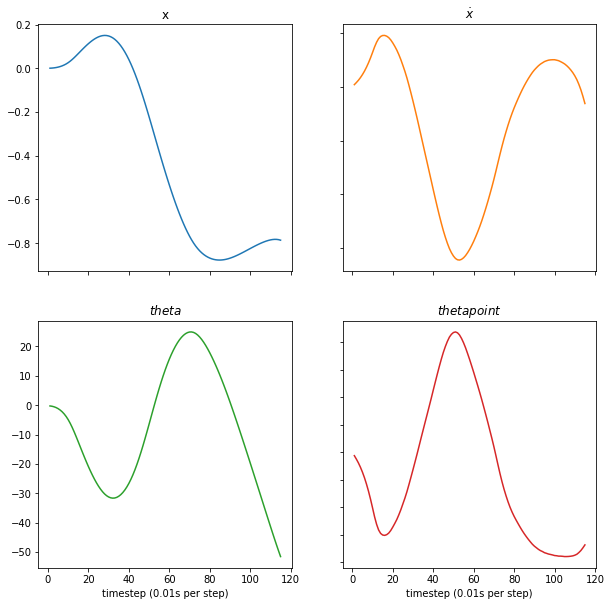

In [44]:
# There. we finished
# Lets see it in action
cartpole=CarPend()
done = False
cnt = 0
observation = cartpole.reset()
t=[]
x=[]
xp=[]
th=[]
thp=[]
while not done :
    cnt += 1
    t.append(cnt)
    action = agentddpg.action(observation)
    observation, reward, done,_ = cartpole.step(action)
    x.append(observation[0])
    xp.append(observation[1])
    th.append(observation[2])
    thp.append(observation[3])


fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10,10))
plt.title('Evolution des paramètres lors d\'une simulation de l\'environnement CarPend, controlé par un agent DDPG entrainé sur 500 épisodes')
axs[0, 0].plot(t, x)
axs[0, 0].set_title('x')
axs[0, 1].plot(t,xp, 'tab:orange')
axs[0, 1].set_title('$\dot x$')
axs[1, 0].plot(t,np.array(th)*180/np.pi, 'tab:green')
axs[1, 0].set_title('$theta$')
axs[1, 1].plot(t,thp, 'tab:red')
axs[1, 1].set_title('$theta point$')

for ax in axs.flat:
    ax.set(xlabel='timestep (0.01s per step)', ylabel='')

#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

### <a id="sec3-2"></a> 3.2. Soft Actor-critic (SAC)
<div id="sac"></div>

Soft Actor-Critic est très proche de DDPG, sauf qu'il apprend en utilisant une entropie régularisée sur la politique des actions.

Soit X une variable aléatoire avec une loi de densité p(X) satisfaisant les exigences de normalisation et de positivité, nous définissons son entropie par
$$-\int_{X} p(x) log (p(x))dx$$

Elle permet de quantifier le désordre d'une variable aléatoire. L'entropie est maximale lorsque X suit une distribution uniforme, et minimale lorsque p(X) est égal à zéro partout sauf dans une valeur, qui est une distribution de Dirac. 



Dans l'algorithme SAC, nous ne considérons pas seulement l'évaluation de la critique dans la loss de l'acteur, mais aussi son entropie de décision.
La loss de l'agent devrait être élevée lorsque l'entropie est faible, car cela l'invitera à explorer davantage.
Plus l'entropie de l'agent est importante, plus il va explorer.


Globalement, notre acteur va calculer deux sorties : La moyenne et l'écart type de la loi normal qui va nous fournir une action. 

Le "soft" dans Soft Actor-Critic fait référence à l'utilisation d'une entropie de politique régularisée pour encourager l'exploration. Cette entropie est une mesure de l'incertitude de la politique et peut être interprétée comme une mesure de l'exploration de l'agent. En régularisant l'entropie de la politique, l'algorithme encourage l'agent à explorer de nouvelles actions plutôt que de s'appuyer uniquement sur des actions qui ont déjà donné de bonnes récompenses.



NB: Les hyperparamètres de l'algorithme sont définis dans la fonction __init__(), et on voit l'utilisation de $\alpha$, ratio entre la valeur du critique et de l'entropie dans l'update du critic.

$$V(s') = TargetCritic(s', a') - alpha * LogProb$$ où $$a', LogProg = SampleAction(s')$$

Des informations utiles et plus détaillées peuvent être trouvées dans [ce document](https://arxiv.org/pdf/1812.05905.pdf)

In [12]:
from torch import optim
import torch.nn.functional as f
from torch.distributions.normal import Normal

class SACAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.0001, critic_lr=0.001, gamma=0.98,
                 max_size=1000000, tau=0.005, layer1_size=128, layer2_size=128, batch_size=128, alpha=1):
        super().__init__(state_space, action_space, device, "SAC")
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size
        self.state_size = state_space.shape[0] 
        self.actions_bounds_range = torch.tensor((action_space.high[0] - action_space.low[0]) / 2).to(self.device)
        self.actions_bounds_mean = torch.tensor(mean((action_space.high[0], action_space.low[0]))).to(self.device)
        self.min_std = 1e-3

        #Reseau acteur
        self.actor = nn.Sequential(nn.Linear(self.state_size, layer1_size), nn.Tanh(),
                                   nn.Linear(layer1_size, layer2_size), nn.Tanh(),
                                   nn.Linear(layer2_size, 2 * self.nb_actions)).to(device=self.device).float()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.target_actor = copy.deepcopy(self.actor)


        #Critic
        self.critic = nn.Sequential(nn.Linear(self.state_size + self.nb_actions, layer1_size), nn.ReLU(),
                                    nn.Linear(layer1_size, layer2_size), nn.ReLU(),
                                    nn.Linear(layer2_size, 1)).to(device=self.device).float()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.target_critic = copy.deepcopy(self.critic)

        self.alpha = alpha ##Ratio entre le critic et l'entropie dans l'update
    
    def converge_to(self, model, other_model, tau=None): ##Meme fonction que dans DDPG
        if tau is None:
            tau = self.tau
        for self_param, other_param in zip(model.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

    def sample_action(self, state, reparameterize=True, actor_network=None):
        if actor_network is None:
            actor_network = self.actor

        # Forward
        if isinstance(state, np.ndarray): ## Si state est un np.array, on le transforme en tenseur torch et l'envoie vers le device utilisé
            state = torch.from_numpy(state).to(self.device)
        actor_output = actor_network(state.float())
        #print('ac_outp', actor_output)
        if len(state.shape) > 1:  #C'est un batch
            actions_means = actor_output[:, :self.nb_actions] ##Moyenne de la loi normale utilisée pour tirer les actions (unique dans notre cas )
            actions_stds = actor_output[:, self.nb_actions:].exp() ## Ecart type de la loi normale utilisée pour tirer les actions (unique dans notre cas)
        else: ## Ce n'est pas un batch
            actions_means = actor_output[:self.nb_actions]
            actions_stds = actor_output[self.nb_actions:].exp() ##On applique la fonction exponentielle pour être sûr de la positivité, le reseau renvoie donc log(std)


        actions_stds = torch.clamp(actions_stds, min=self.min_std, max=1)
        #print('act_stds', actions_stds)
        actions_distribution = Normal(actions_means, actions_stds) #Distribution de laquelle on va tirer notre action

        if reparameterize: #Reparametrization trick: permet de pouvoir différentier le tirage dans la loi normale via rsample()
            actions = actions_distribution.rsample()
        else:
            actions = actions_distribution.sample()
        #print('act',actions)
        action = torch.tanh(actions) * self.actions_bounds_range + self.actions_bounds_mean #On envoie notre action dans l'espace d'actions
        #print('action_', action)


        #calcul de la log_prob de l'action :
        log_probs = actions_distribution.log_prob(action) 
        log_probs -= torch.log(1 - action.pow(2) + self.min_std) 
        log_probs = log_probs.sum(dim=-1)


        return action, log_probs

    def action(self, state):
        actions, _ = self.sample_action(state, reparameterize=True)

        return actions.cpu().detach().numpy()

    def learn(self): ##Processus d'entrainement de l'algorithme

        if len(self.replay_buffer) > self.batch_size: #on ne l'entraine que s'il y a plus d'un batch dans le replay buffer
            states, actions, rewards, next_states, done = self.replay_buffer.sample(self.batch_size)

            # Training critic
            with torch.no_grad():
                next_actions, next_log_probs = self.sample_action(next_states, actor_network=self.target_actor)
                next_q_values = self.target_critic.forward(torch.cat((next_states, next_actions), -1)).view(-1)

            q_hat = rewards + self.gamma * (1 - done) * (next_q_values - self.alpha * next_log_probs)

            self.critic_optimizer.zero_grad()
            q_values = self.critic.forward(torch.cat((states, actions), 1)).view(-1)
            critic_loss = f.mse_loss(q_values, q_hat)
            critic_loss.backward()
            self.critic_optimizer.step()
            
            self.converge_to(self.target_critic, self.critic)

            # Train actor
            actions, log_probs = self.sample_action(states, reparameterize=True)
            log_probs = log_probs.view(-1)
            critic_values = self.critic.forward(torch.cat((states, actions), -1)).view(-1)

            actor_loss = log_probs - critic_values
            actor_loss = torch.mean(actor_loss)
            self.actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            self.actor_optimizer.step()
            
            self.converge_to(self.target_actor, self.actor)

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)


#### <a id="sec3-2-1"></a> 3.2.1. Essai sur environnement jouet CarPend

In [13]:
environment = CarPend(max_time=700)
agentsac = SACAgent(environment.observation_space, environment.action_space, device=DEVICE)
reward_sac=simulation(environment, agentsac, nb_episodes=500)

Episode   0, episode return 75.0, last 20 avg 75.0
Episode   5, episode return 71.0, last 20 avg 97.7
Episode  10, episode return 130.0, last 20 avg 102.4
Episode  15, episode return 82.0, last 20 avg 101.6
Episode  20, episode return 81.0, last 20 avg 99.8
Episode  25, episode return 100.0, last 20 avg 97.3
Episode  30, episode return 91.0, last 20 avg 93.7
Episode  35, episode return 106.0, last 20 avg 94.2
Episode  40, episode return 95.0, last 20 avg 94.3
Episode  45, episode return 89.0, last 20 avg 95.4
Episode  50, episode return 83.0, last 20 avg 94.7
Episode  55, episode return 88.0, last 20 avg 93.2
Episode  60, episode return 83.0, last 20 avg 92.8
Episode  65, episode return 102.0, last 20 avg 93.2
Episode  70, episode return 79.0, last 20 avg 91.8
Episode  75, episode return 108.0, last 20 avg 92.7
Episode  80, episode return 95.0, last 20 avg 93.1
Episode  85, episode return 81.0, last 20 avg 90.0
Episode  90, episode return 78.0, last 20 avg 90.4
Episode  95, episode ret

Executer cette cellule pour sauvegarder l'agent

In [ ]:

torch.save(agentsac.actor.state_dict(), 'carpend_jouet_act_checkpoint_sac.pth')
torch.save(agentsac.critic.state_dict(), 'carpend_crit_checkpoint_sac.pth')

In [23]:
#Sum Up: 

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

data_s = np.array(reward_sac)
data_ddpg=np.array(rewards)
movs=moving_average(data_s,10)
movd=moving_average(data_ddpg,10)

movs=np.concatenate((data_s[:9],movs))
movd=np.concatenate((data_ddpg[:9],movd))


# <a id="sec4"></a> 4. Évolution des rewards selon les algorithmes

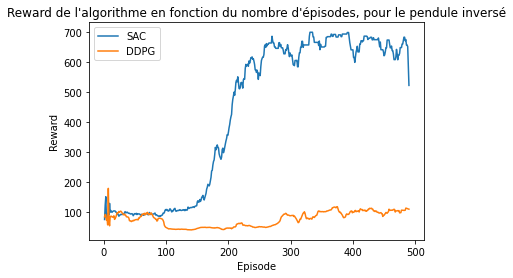

In [25]:
plt.figure()
plt.plot(range(1,491),movs[:490], label='SAC')
plt.plot(range(1,491),movd[:490], label='DDPG')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Reward de l\'algorithme en fonction du nombre d\'épisodes, pour le pendule inversé')
plt.show()